In [ ]:
Objective : To deterimine anomalies in comment present in each topic wise comments that topic words do not contain, to get anchor information .Used DBSCAN & LO detection method. as they are unsupervised, density based methods and mostly commonly used for outlier detection using text data.

Conclusion : Mostly for all topics the anomalies generated from DBSCAN & LOF the anomalies could differentated into three categories
1) noise data , not useful comments like agreed as per analyst recommendation, 'no hit' in fico system previously, customer does have any product with maybank for further business reference
,as per comm 35, watch person status is "del/sc",agree to maker is recommendation to close the alert as advice from gfcc is discounting comment
no further reviews is required by analyst as the watch list record has been replaced with an updated record with active status/deleted from datebase,
noisy comments like FH , True hit non material, only web links and some importnant websites.
2) anchors not present in topic words 
i)unknown identifoers not present in topic words -deceased date v/s date of on boarding Malaysia , deceased date  v/s customer cif creation date
(deceased anchor not present in topic words)

mismatch date of birth (dob)
watch person is deceased (deceased date   :22-aug-2022 as per refinitiv)

ii) pep rca discounting - wl 6395672 & 8174655 - mismatched nric
wl 2769689 - mismatched profile
labourer vs pep


iii) mis match profile with customer opened account and now watch list is fined by sebi not to participate in trading activities , some other narration involving sebi,


3)same anchors but different narration - 
mismatch profile - customer was granted a prepaid credit card on 22/01/2019 and the account was active until 22/01/2019 account number 4159390101263321 with the current balance of rm -25.77. based on fomema search, customer has updated his medical report 24/04/2018 and the status valid until 24/10/2018. this shows that the customer is still gainfully employed in malaysia. as per watch person, on nov 2012, he was reportedly detained in multan and apr 2022, there is no further information reported. therefore, it is unlikely for the customer and watch person to be the same person. if customer were to activate his account or obtain any product with maybank fresh kyc/ecdd/name 
screening will be conducted by the business unit. therefore, the access risk will be mitigated during the stringent on-boarding procedure.

ii)customer opened act 110014138565 on 09/10/2006 and his current balance as at today is rm13.43.
as per apex transaction his last activity was cash withdrawal made in klia airport lcct in 2015 . his sa act has been dormant for almost 7 years and pending closing by system. watch person is  a member of shan state hluttaw .other than having common names there no unique identifier available on watch person that can be used to conclude that both are the same person. . since account is dormant if customer wants to activate his account our risk will be mitigated by our stringent requirement on activation of dormant account guidelines. (mal/bkgops/admin/123/1). whereby customer has to present fresh travelling
document for ecdd, name screening checking before he is allowed to activate his account.


iii) false hit. 
according to refinitive, watchperson was reportedly deceased on 29-oct-2015 meanwhile customer on-boarded maybank on 17/06/2020



Approach: Did pre-processing on comments then obtained pooled bert embeddings,we perform scaling and then feed those embeddings to DBSCAN model.To determine the amount of Anomalies.
1)To create DBSCAN model we require to input two parameters- min samples and epsilon.Epsilon using K-distance  
Min_ samples should be atleast greater than features.but here the feature counts is 768 and sample counts is 600 in cluster 13 .Hence if we take it 769 so all points shall come in one cluster
.We started providing a range of values starting from 1/10th sample 50 ,70, 90, but results no. of clusters changes from 2-3. Objective was to to take in loop an increment of 
1/5 th sample and then find out which min sample produces the maximum no. of cluster..Since we wanted to follow the same approach of not having to high or low min samples as clusters may be very low or very high .

2)Another approach would to use grid search with metric as sihoutte score

But since we wanted to focus on anomalies, and the base models mostly had 1 , 2, 3, clusters.Need to evaluate the clusters of DBSCAN so used 
silhoutte score , but in many topics only two clusters were there 0 & -1 , -1 are discareded while obtaining silhoutte score, hence cannot evaluate the silhoutte score. Hence thought of other approach density based approach  i.e. local outlier factor.

For LOF, need to provide two inputs - neighbours and contamination. Prepared as base line model and then finut une using grid search amd silhoutte score as
metric to get optimum value for both.

Now use anomalies from both , to make manual observation since this approach is part of EDA.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import word2vec
import numpy as np
import pandas as pd
import ast
import re
import torch
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [2]:
# import dataiku
import os

In [3]:
# folder_path=dataiku.Folder("Name Screening notebooks").get_path()
# path_folder=os.path.join(folder_path,"Output_of_topic_modelling_final_20_bi_tri_2.csv")
df=pd.read_csv("C:/Users/MBBLABS/Topic-Modelling/Output_of_topic_modelling_final_20_bi_tri_2.csv")


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [4]:
df.head()
df.drop(["Unnamed: 0","Unnamed: 0.1"],axis=1,inplace=True)

In [5]:
df

,V_COMMENTS,Counts,V_COMMENTS_2,Tokens,id_2_feature,TFIDF_Feature,Topic_tfidf_lda,All_Topic_tfidf_Probabilities,TF_tfidf_Topic_No,TF IDF Topic words
0,mismatch id number_nric,67150,mismatch id number nric,"['mismatch', 'i', 'd', 'number', 'nric']","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]","[(0, 0.547290750424587), (1, 0.547516376900071...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.037396688), (1, 0.03744973), (2, 0.0373...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
1,mismatch id number_nric\n,40137,mismatch id number nric,"['mismatch', 'i', 'd', 'number', 'nric']","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]","[(0, 0.547290750424587), (1, 0.547516376900071...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.037396688), (1, 0.037449747), (2, 0.037...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
2,mismatch year of birth (yob),27341,mismatch year birth yob,"['mismatch', 'year', 'birth', 'yob']","[(2, 1), (5, 1), (6, 1), (7, 1)]","[(2, 0.06249879031496278), (5, 0.5453915180875...","0.162*""yob"" + 0.111*""year"" + 0.073*""birth"" + 0...","[(0, 0.038604278), (1, 0.038610753), (2, 0.038...",3,"['yob', 'year', 'birth', 'infer', 'bear', 'ref..."
3,mismatch id number_nric,25793,mismatch id number nric,"['mismatch', 'i', 'd', 'number', 'nric']","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]","[(0, 0.547290750424587), (1, 0.547516376900071...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.037396688), (1, 0.037449766), (2, 0.037...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
4,mismatch full legal name – name does not sound...,19127,mismatch full name sound similar,"['mismatch', 'full', 'name', 'sound', 'similar']","[(2, 1), (8, 1), (9, 1), (10, 1), (11, 1)]","[(2, 0.030451784805766515), (8, 0.473060193932...","0.137*""name"" + 0.051*""match"" + 0.039*""full"" + ...","[(0, 0.037577048), (1, 0.040632684), (2, 0.037...",17,"['name', 'match', 'full', 'passport', 'similar..."
...,...,...,...,...,...,...,...,...,...,...
221569,"mismatch - name, nric, date of birth, profile,...",1,mismatch name nric date birth profile customer...,"['mismatch', 'name', 'nric', 'date', 'birth', ...","[(2, 1), (3, 3), (4, 1), (5, 3), (9, 3), (12, ...","[(2, 0.005990920965347929), (3, 0.227682171168...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.02934474), (1, 0.031117253), (2, 0.0294...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
221570,"mismatch - name, nric, date of birth, profile,...",1,mismatch name nric date birth profile customer...,"['mismatch', 'name', 'nric', 'date', 'birth', ...","[(2, 1), (3, 3), (4, 1), (5, 3), (9, 3), (12, ...","[(2, 0.0085888069800516), (3, 0.32641362359475...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.031628136), (1, 0.033863842), (2, 0.031...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
221571,mismatch id number_nric. watch person (noraini...,1,mismatch id number nric watch person bank cus...,"['mismatch', 'i', 'd', 'number', 'nric', 'watc...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (15, ...","[(0, 0.27243957135183583), (1, 0.2725518874840...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.03383267), (1, 0.033776768), (2, 0.0337...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."
221572,mismatch id number_nric. watch person (noraini...,1,mismatch id number nric watch person bank cus...,"['mismatch', 'i', 'd', 'number', 'nric', 'watc...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (15, ...","[(0, 0.27243957135183583), (1, 0.2725518874840...","0.199*""nric"" + 0.130*""date"" + 0.085*""birth"" + ...","[(0, 0.03383269), (1, 0.03377677), (2, 0.03370...",4,"['nric', 'date', 'birth', 'number', 'd', 'i', ..."


In [6]:
import calendar
cal=list(calendar.month_name)
for i in list(calendar.month_name[1:]):
    cal.append(i[:3])

In [7]:
patt1=re.compile("Match ID and/or Full Legal Name",re.IGNORECASE)
# patt2=re.compile("Agreed with analyst recommendation|Agreed with analyst's recommendation|Agreed as per Maker comment|Agreed as per Maker's comment")
patt2=re.compile("(Agreed|agree) (to|with|as per) (analyst(('s)*)|maker(('s)*)) (comment|recommendation|is recommendation)",re.IGNORECASE)
patt3=re.compile("Unknown|false hit\.*|true hit\.*|Rationale|Source",re.IGNORECASE)
patt4=re.compile("CSCDD7|CSCDD1|CSCDD4",re.IGNORECASE)
patt5=re.compile("SCC6|No further review is required by analyst|SC/DEL",re.IGNORECASE)
patt6=re.compile("https?://\S+|www\.\S+",re.IGNORECASE)
patt7=re.compile("(%s)"%"|".join(cal)[1:],re.IGNORECASE)
patt8=re.compile("\s*(Mohd|NORAINI|ABDULLAH|BINTI|system|legal|stated|ABD|mahdzir|bin|khalid|siti|hajar|mohd|sallehudin|mohd|saddam|inie|binti|abdullah|noraini|norliza|binti|othman)\s*",re.IGNORECASE)


In [8]:
df.dropna(inplace=True)

In [9]:

df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS"].apply(lambda x: re.sub("\n"," ",x)) #1

df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("Name – Name","Name",x))    #2
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("Name_Name","Name",x))      #3
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("\s*_\s*|\s*-\s*"," ",x)) #4,5
df=df[df["V_COMMENTS_PROCESSED"].str.contains(patt1)==False] #7
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt2,"",x)) #8
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt3,"",x))  #  9
df=df[df["V_COMMENTS_PROCESSED"].str.contains(patt4)==False]        # 10
df=df[df["V_COMMENTS_PROCESSED"].str.contains(patt5)==False]       #11
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt6,"",x)) #15
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("[^\w\s\.]|\d","",x))
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub("\d*","",x))    #date, year, accounts 6
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt7,"",x))    # month 6
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].apply(lambda x: re.sub(patt8," ",x)) # 17


In [10]:
df=df[df["V_COMMENTS_PROCESSED"].apply(lambda x : len(x)!=0)]
df["V_COMMENTS_PROCESSED"]=df["V_COMMENTS_PROCESSED"].str.lower()


In [11]:
df["V_COMMENTS_PROCESSED"]

0                                   mismatch id number nric
1                                  mismatch id number nric 
2                                mismatch year of birth yob
3                                   mismatch id number nric
4           mismatch full name  name does not sound similar
                                ...                        
221569    mismatch name nric date of birth profile   cus...
221570    mismatch name nric date of birth profile   cus...
221571    mismatch id number nric. watch person    is a ...
221572    mismatch id number nric. watch person    is a ...
221573    mismatch profile as adverse news reported   de...
Name: V_COMMENTS_PROCESSED, Length: 221532, dtype: object

In [12]:
df_groups=df.groupby("TF_tfidf_Topic_No")
df["TF_tfidf_Topic_No"].value_counts().sort_values(ascending=False)

TF_tfidf_Topic_No
6     41846
3     31042
14    25252
4     18335
8     15784
5     13528
10    12982
17    10520
16     9395
0      9306
1      8627
9      6395
12     5418
11     4608
19     2773
7      1916
15     1124
2      1070
18      953
13      658
Name: count, dtype: int64

In [147]:
# df["Comments_Processed"]
# max_length=max(df["V_COMMENTS_TOKENS"].apply(lambda x: len(x)))

In [13]:
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")
model=BertModel.from_pretrained("bert-base-uncased")

In [14]:
# Function to process a single pair of sentences and return the CLS token embedding
def process_pair(sentence1):
    # Tokenize sentences and add special tokens
    tokens = tokenizer(sentence1,return_tensors='pt', padding=True, truncation=True)
    
    # Pass tokenized input to BERT model to obtain CLS token embeddings
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Extract CLS token embeddings
    cls_embedding = outputs.pooler_output
    
    return cls_embedding


## DBSACN - 13

In [15]:
df_13=df_groups.get_group(13)
# vectors=embeddings

In [162]:
embeddings = []
for _, row in df_groups.get_group(13).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

# Stack the embeddings into a single tensor
# embeddings_tensor = torch.stack(embeddings)



In [163]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [177]:
# Scaling of embeddings

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
std_emb=sc.fit_transform(embeddings_arr)



In [165]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=4)   # We first
nbrs = neigh.fit(std_emb)

In [169]:
std_emb

array([[-1.05477902, -0.07517636,  0.81988467, ...,  0.68783273,
        -1.02828364,  1.22855102],
       [-0.56134377, -0.11788741, -0.0101364 , ...,  0.30445873,
        -1.05972253,  0.91179449],
       [ 0.23014823,  1.0304375 , -0.26404376, ..., -0.37796259,
         0.56390144, -1.00895197],
       ...,
       [-1.2398892 , -1.29527581,  0.13050498, ...,  0.00453674,
        -1.03823904,  1.50658451],
       [-1.2398892 , -1.29527581,  0.13050498, ...,  0.00453674,
        -1.03823904,  1.50658451],
       [-1.2398892 , -1.29527581,  0.13050498, ...,  0.00453674,
        -1.03823904,  1.50658451]])

K-distance plot - Here we determine the top few neighbours and therir distances from every data point.Now sort them at feature /column manner in asceding order.Pick the first column and plot is against data points.Now where curvature changes sharply , becomes our choise of k/ epsilon

In [166]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)   # We first
nbrs = neigh.fit(std_emb)


In [167]:
distances,indices=nbrs.kneighbors(std_emb)


In [170]:
indices

array([[ 25,   8,  14,   0],
       [ 89,   1,   6, 331],
       [  2,  15, 427, 621],
       ...,
       [657, 656, 655, 654],
       [657, 656, 655, 654],
       [657, 656, 655, 654]], dtype=int64)

In [171]:
x=np.array([[8,5,6],[8,6,3],[7,3,1]])
np.sort(x,axis=0)

array([[7, 3, 1],
       [8, 5, 3],
       [8, 6, 6]])

In [172]:
distances

array([[9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07],
       [1.11828226e-06, 1.11828226e-06, 1.11828226e-06, 1.11828226e-06],
       [8.92080638e-07, 6.78591140e-01, 6.78591140e-01, 7.36070178e-01],
       ...,
       [9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07],
       [9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07],
       [9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07]])

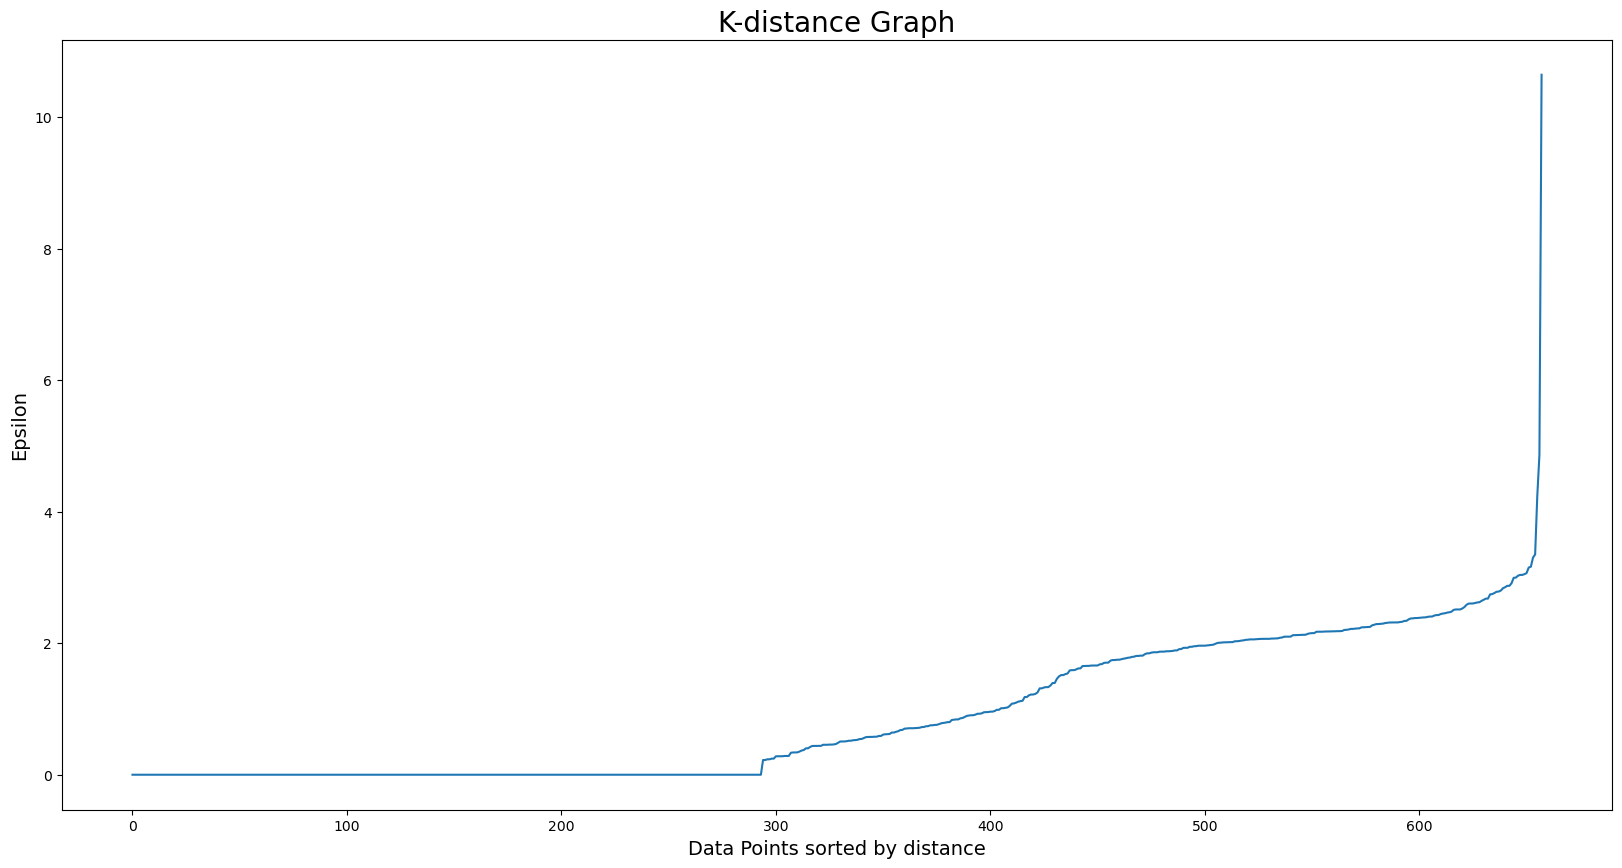

In [173]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [174]:

dbscan = DBSCAN(eps=4.0, min_samples=80)
dbscan.fit(std_emb)
cluster_labels = dbscan.labels_
coords = std_emb
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [175]:
cluster_labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [176]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 1
Estimated no. of noise points: 658


In [178]:
df_13["Cluster_label"]=cluster_labels

In [179]:
df_13["Cluster_label"].unique()

array([-1], dtype=int64)

In [44]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder_13=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/13th_topic.csv")


df_13.to_csv(path_folder_13)


Silhoutte score calculation

In [180]:
# # Metric measurement - sihoutte score - we are suppose to remove the anomalies and then see the score.
# dbscan = DBSCAN(eps=0.3, min_samples=10)
# labels = dbscan.fit_predict(X)

# Filter out noise points
# core_samples_mask = labels != -1
filtered_X = df_13[df_13["Cluster_label"]!=-1]
filtered_labels = cluster_labels[cluster_labels!=-1]


# Calculate silhouette score
if len(set(filtered_labels)) > 1:  # Silhouette score needs at least 2 clusters
    score = silhouette_score(filtered_X, filtered_labels)
    print("Silhouette Score:", score)
else:
    print("Not enough clusters to calculate silhouette score")


Not enough clusters to calculate silhouette score


Not enough clusters to calculate silhouette score


### Local Outlier factor - topic 13

In [181]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [38]:
# Scaling of embeddings

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
std_emb=sc.fit_transform(embeddings_arr)



In [182]:

# TF-IDF vectorization
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(df_grp["V_COMMENTS_2"].get_group(9).values)

# Apply Local Outlier Factor
n_neighbors = 125
contamination = 0.25 # Percentage of outliers expected in the dataset
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
outlier_labels = lof.fit_predict(embeddings_arr)




In [183]:
df_13["cluster_labels"]=outlier_labels

In [184]:
df_13["cluster_labels"].unique()

array([ 1, -1])

In [185]:
# Define parameter grid
param_grid = {
    'n_neighbors': [50, 70,100,150],
    'contamination': [0.5, 0.1, 0.2,0.4,]
}





# Perform grid search with unsupervised evaluation
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid, scoring=silhouette_score)
grid_search.fit(embeddings_arr)  # X: feature matrix

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate silhouette score
silhouette = silhouette_score(embeddings_arr, grid_search.best_estimator_.negative_outlier_factor_)
print("Silhouette Score:", silhouette)


Best Parameters: {'contamination': 0.5, 'n_neighbors': 50}
Silhouette Score: 0.44680843


In [ ]:
# Apply Local Outlier Factor
n_neighbors = 50
contamination = 0.5 # Percentage of outliers expected in the dataset
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
outlier_labels = lof.fit_predict(embeddings_arr)


## DBSCAN -18

In [205]:
embeddings = []
for _, row in df_groups.get_group(18).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

df_18=df_groups.get_group(18)
vectors=embeddings
embeddings_arr_18=[i.numpy().flatten() for i in embeddings]

In [206]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
std_emb=sc.fit_transform(embeddings_arr_18)

In [228]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embeddings_arr_18)


In [229]:
distances,indices=nbrs.kneighbors(embeddings_arr_18)


In [230]:
indices

array([[  0, 389, 735,  37],
       [ 11,   1,  65, 400],
       [  2, 711, 548, 375],
       ...,
       [950, 842, 326,  64],
       [951, 379,  95, 659],
       [952, 515, 949, 940]], dtype=int64)

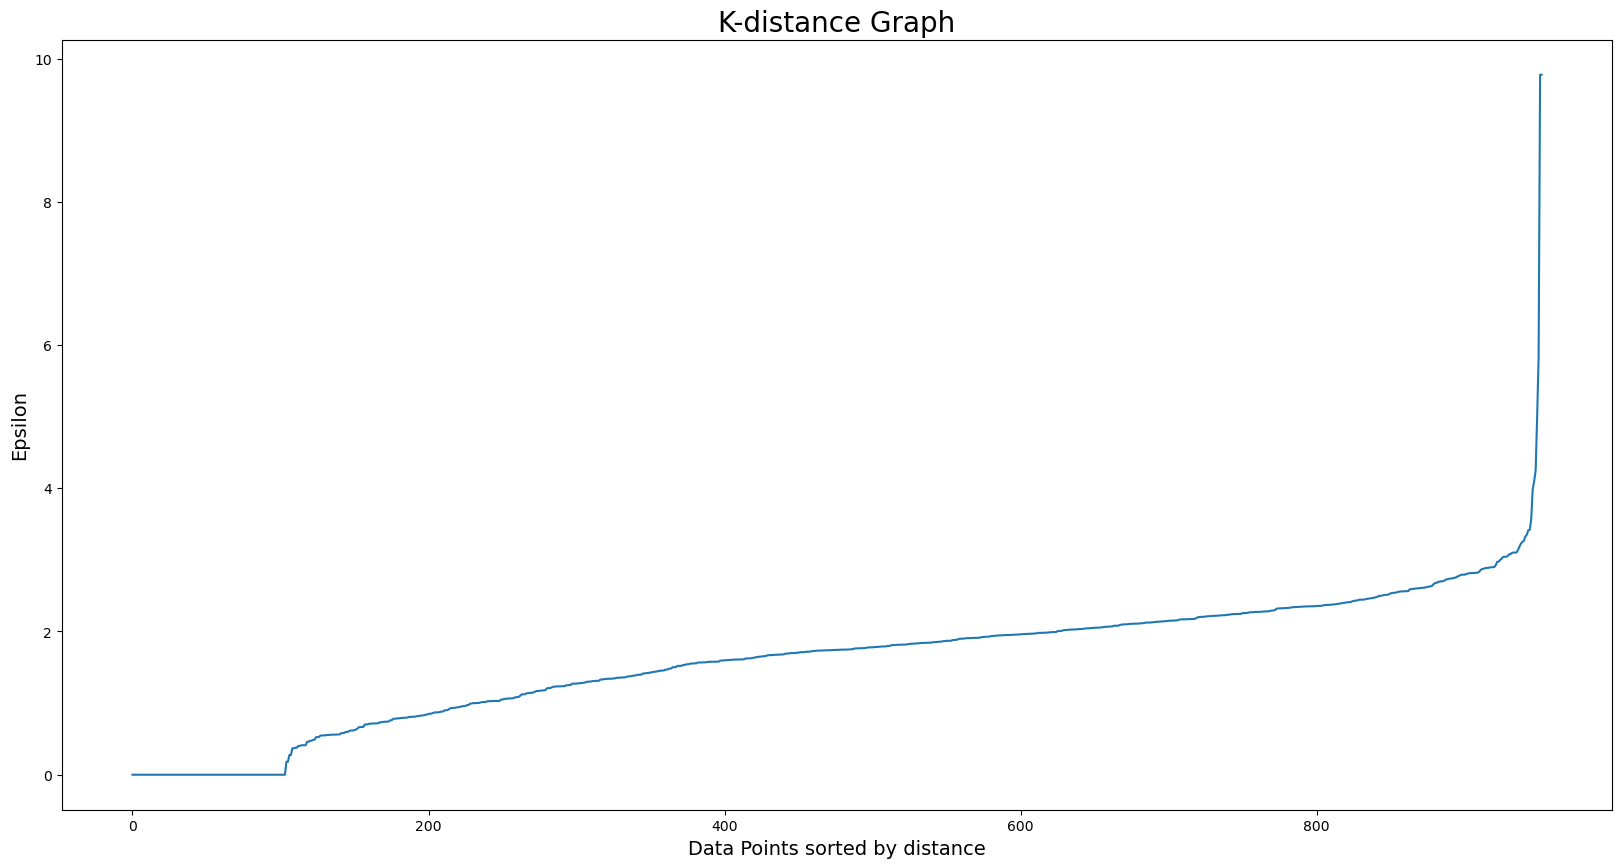

In [231]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [232]:

dbscan = DBSCAN(eps=4, min_samples=50)
dbscan.fit(embeddings_arr_18)
cluster_labels = dbscan.labels_
coords = std_emb
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [233]:
cluster_labels

array([ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
       -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [234]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 16


In [235]:
df_18["Cluster_label"]=cluster_labels

In [236]:
df_18["Cluster_label"].unique()

array([ 0, -1], dtype=int64)

In [237]:
# Filter out noise points
# core_samples_mask = labels != -1
filtered_X = df_18[df_18["Cluster_label"]!=-1]
filtered_labels = cluster_labels[cluster_labels!=-1]


# Calculate silhouette score
if len(set(filtered_labels)) > 1:  # Silhouette score needs at least 2 clusters
    score = silhouette_score(filtered_X, filtered_labels)
    print("Silhouette Score:", score)
else:
    print("Not enough clusters to calculate silhouette score")

Not enough clusters to calculate silhouette score


### Local Outlier factor - topic 18

array([-1,  1])

In [242]:
# Define parameter grid
param_grid = {
    'n_neighbors': [50, 70,100,150],
    'contamination': [0.5, 0.1, 0.2,0.4,]
}





# Perform grid search with unsupervised evaluation
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid, scoring=silhouette_score)
grid_search.fit(embeddings_arr_18)  # X: feature matrix

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate silhouette score
silhouette = silhouette_score(embeddings_arr_18, grid_search.best_estimator_.negative_outlier_factor_)
print("Silhouette Score:", silhouette)


Best Parameters: {'contamination': 0.5, 'n_neighbors': 50}
Silhouette Score: 0.109129034


In [ ]:

# TF-IDF vectorization
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(df_grp["V_COMMENTS_2"].get_group(9).values)

# Apply Local Outlier Factor
n_neighbors = 0.5
contamination = 50 # Percentage of outliers expected in the dataset
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
outlier_labels = lof.fit_predict(embeddings_arr_18)


In [ ]:
df_18["cluster_labels_lof"]=outlier_labels

In [98]:
df_18["cluster_labels_lof"].unique()

In [243]:
df_18.to_csv("C:/Users/MBBLABS/Clustering_-_Anomaly_detection/18th_topic.csv")


## DBSCAN -2

In [264]:
embeddings_2 = []
for _, row in df_groups.get_group(2).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings_2.append(cls_embedding)

In [245]:
df_2=df_groups.get_group(2)
vectors=embeddings_2

In [246]:
embeddings_arr_2=[i.numpy().flatten() for i in embeddings_2]

In [247]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
std_emb=sc.fit_transform(embeddings_arr_2)

In [248]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(std_emb)


In [249]:
distances,indices=nbrs.kneighbors(std_emb)


In [250]:
indices

array([[   0,  540,  186,  156],
       [ 193,    1,  352,  657],
       [   2,   19,  550,  661],
       ...,
       [1067,  723, 1065,  548],
       [1068,  322,  754,  345],
       [1069,  382,  581,  265]], dtype=int64)

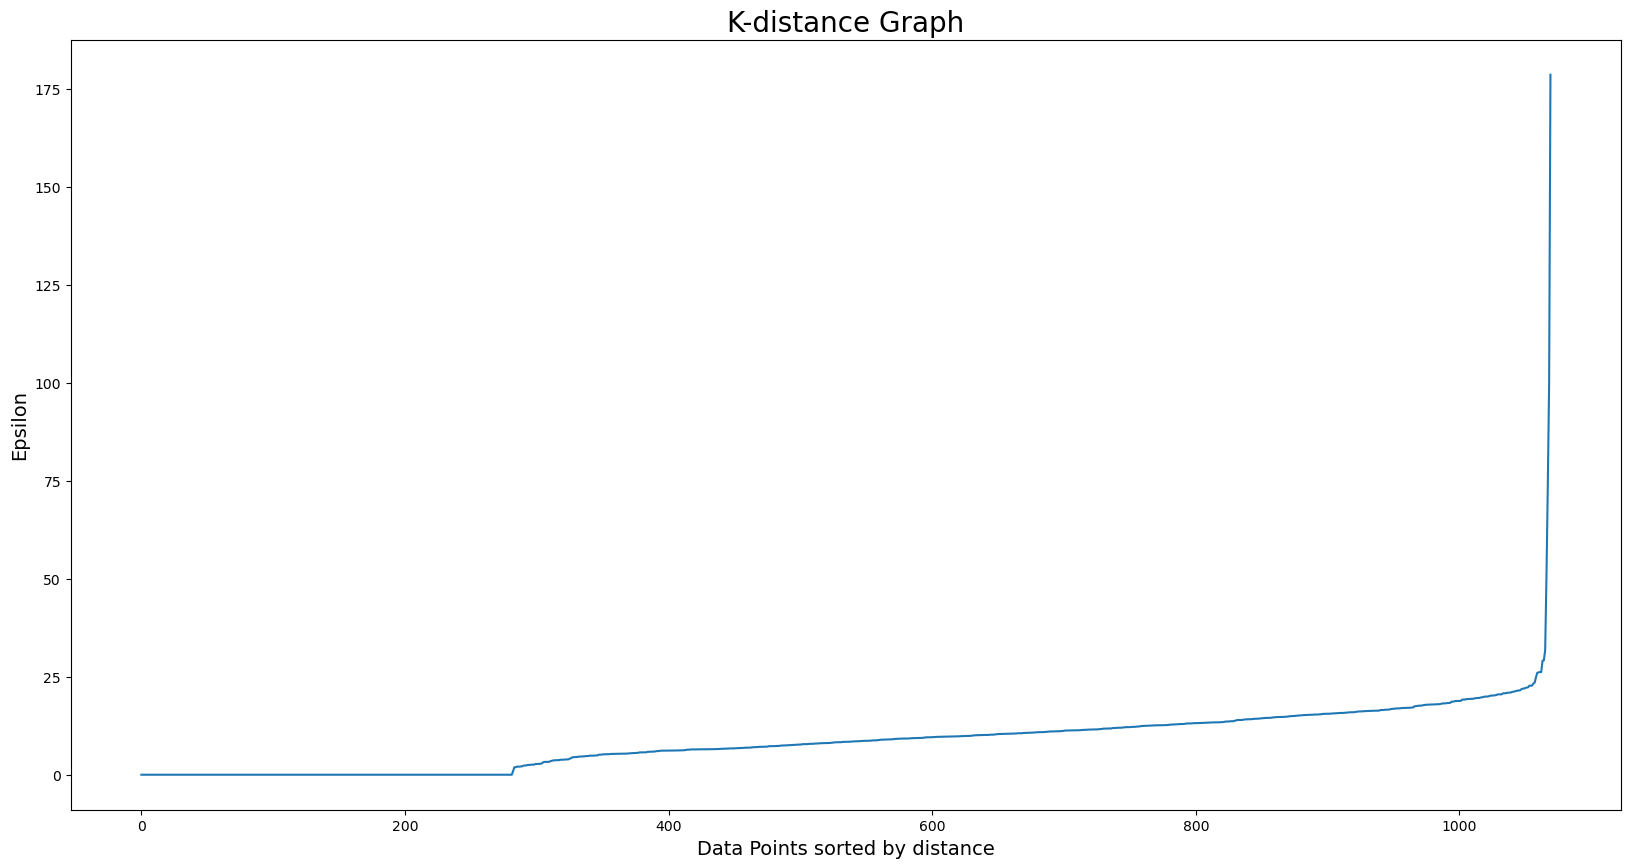

In [251]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [252]:

dbscan = DBSCAN(eps=25.0, min_samples=50)
dbscan.fit(std_emb)
cluster_labels = dbscan.labels_
coords = std_emb
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [253]:
cluster_labels

array([ 0, -1,  0, ...,  0,  0,  0], dtype=int64)

In [254]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 50


In [255]:
df_2["Cluster_label"]=cluster_labels

In [157]:
# folder_path=dataiku.Folder("Name Screening notebooks").get_path()
# path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/2nd_topic.csv")
# df_2.to_csv(path_folder)

In [158]:
# df_2.shape
# df_2.to_csv("2nd_topic.csv")

In [256]:
# Filter out noise points
# core_samples_mask = labels != -1
filtered_X = df_2[df_2["Cluster_label"]!=-1]
filtered_labels = cluster_labels[cluster_labels!=-1]


# Calculate silhouette score
if len(set(filtered_labels)) > 1:  # Silhouette score needs at least 2 clusters
    score = silhouette_score(filtered_X, filtered_labels)
    print("Silhouette Score:", score)
else:
    print("Not enough clusters to calculate silhouette score")

Not enough clusters to calculate silhouette score


### Local Outlier factor - topic 2

In [272]:

# TF-IDF vectorization
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(df_grp["V_COMMENTS_2"].get_group(9).values)

# Apply Local Outlier Factor
n_neighbors = 125
contamination = 0.25 # Percentage of outliers expected in the dataset
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
outlier_labels = lof.fit_predict(std_emb)




In [273]:
df_2["cluster_labels_lof"]=outlier_labels

In [274]:
df_2["cluster_labels_lof"].unique()

array([-1,  1])

In [275]:
# Define parameter grid
param_grid = {
    'n_neighbors': [50, 70,100,150],
    'contamination': [0.5, 0.1, 0.2,0.4,]
}





# Perform grid search with unsupervised evaluation
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid, scoring=silhouette_score)
grid_search.fit(std_emb)  # X: feature matrix

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate silhouette score
silhouette = silhouette_score(std_emb, grid_search.best_estimator_.negative_outlier_factor_)
print("Silhouette Score:", silhouette)


Best Parameters: {'contamination': 0.5, 'n_neighbors': 50}
Silhouette Score: 0.23831774780826898


In [278]:
df_2.to_csv("C:/Users/MBBLABS/Clustering_-_Anomaly_detection/2nd_topic.csv")

### DBSCAN -15

In [303]:
embeddings = []
for _, row in df_groups.get_group(15).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [304]:
df_15=df_groups.get_group(15)
# vectors=embeddings

In [305]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [318]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
std_emb=sc.fit_transform(embeddings_arr)

In [319]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(std_emb)


In [320]:
distances,indices=nbrs.kneighbors(std_emb)


In [321]:
indices

array([[  18,   17,    9,    0],
       [  44,    1,  327,  322],
       [   2,  648,  644,  664],
       ...,
       [1121, 1122,  280,   81],
       [1122, 1121,  280,   81],
       [  41,    7,   36,    5]], dtype=int64)

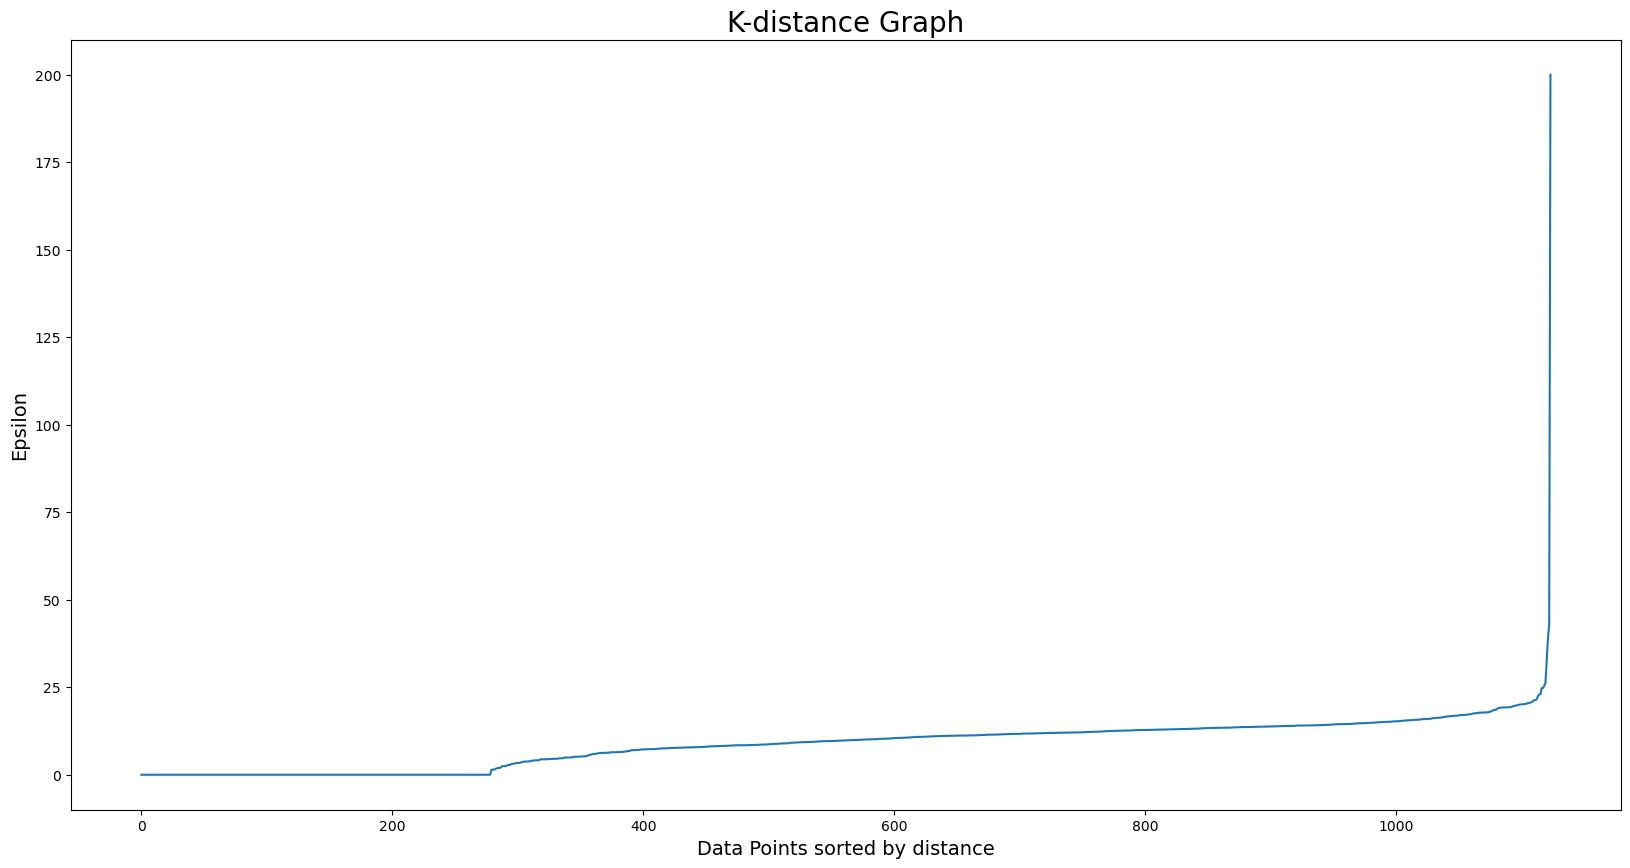

In [322]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [325]:

dbscan = DBSCAN(eps=25.0, min_samples=50)
dbscan.fit(std_emb)
cluster_labels = dbscan.labels_
coords = std_emb
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [326]:
cluster_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [327]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 46


In [328]:
df_15["Cluster_label"]=cluster_labels

### Local Outlier factor - topic 15

In [ ]:
Anomaly comments involve  -  noisy comments like FH , True hit non material, only web links and some importnant websites , some common anchors but with different narration like 
mis match profile with customer opened account and now watch list is fined by sebi not to participate in trading activities , some other narration involving sebi,


In [332]:
# Define parameter grid
param_grid = {
    'n_neighbors': [50, 70,100,150],
    'contamination': [0.5, 0.1, 0.2,0.4,]
}





# Perform grid search with unsupervised evaluation
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid, scoring=silhouette_score)
grid_search.fit(std_emb)  # X: feature matrix

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate silhouette score
silhouette = silhouette_score(std_emb, grid_search.best_estimator_.negative_outlier_factor_)
print("Silhouette Score:", silhouette)


Best Parameters: {'contamination': 0.5, 'n_neighbors': 50}
Silhouette Score: 0.19217080887871205


In [333]:
# TF-IDF vectorization
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(df_grp["V_COMMENTS_2"].get_group(9).values)

# Apply Local Outlier Factor
n_neighbors = 50
contamination = 0.5 # Percentage of outliers expected in the dataset
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
outlier_labels = lof.fit_predict(std_emb)

In [335]:
df_15["cluster_labels_lof"]=outlier_labels

In [336]:
df_15["cluster_labels_lof"].unique()

array([ 1, -1])

In [337]:
df_15.to_csv("C:/Users/MBBLABS/Clustering_-_Anomaly_detection/15th_topic.csv")

### DBSCAN -7

In [ ]:
anomalies involve - noisy data like alert has been closed as 'no hit' in fico system previously, customer does have any product with maybank for further business reference
,as per comm 35, watch person status is "del/sc",agree to maker is recommendation to close the alert as advice from gfcc is discounting comment
no further reviews is required by analyst as the watch list record has been replaced with an updated record with active status/deleted from datebase,
2)unknown identifoers not present in topic words -deceased date v/s date of on boarding Malaysia , deceased date  v/s customer cif creation date
(deceased anchor not present in topic words)

mismatch date of birth (dob)
watch person is deceased (deceased date   :22-aug-2022 as per refinitiv)

ii) pep rca discounting - wl 6395672 & 8174655 - mismatched nric
wl 2769689 - mismatched profile
labourer vs pep

3)same anchors but different narration - 
mismatch profile - customer was granted a prepaid credit card on 22/01/2019 and the account was active until 22/01/2019 account number 4159390101263321 with the current balance of rm -25.77. based on fomema search, customer has updated his medical report 24/04/2018 and the status valid until 24/10/2018. this shows that the customer is still gainfully employed in malaysia. as per watch person, on nov 2012, he was reportedly detained in multan and apr 2022, there is no further information reported. therefore, it is unlikely for the customer and watch person to be the same person. if customer were to activate his account or obtain any product with maybank fresh kyc/ecdd/name 
screening will be conducted by the business unit. therefore, the access risk will be mitigated during the stringent on-boarding procedure.

ii)customer opened act 110014138565 on 09/10/2006 and his current balance as at today is rm13.43.
as per apex transaction his last activity was cash withdrawal made in klia airport lcct in 2015 . his sa act has been dormant for almost 7 years and pending closing by system. watch person is  a member of shan state hluttaw .other than having common names there no unique identifier available on watch person that can be used to conclude that both are the same person. . since account is dormant if customer wants to activate his account our risk will be mitigated by our stringent requirement on activation of dormant account guidelines. (mal/bkgops/admin/123/1). whereby customer has to present fresh travelling
document for ecdd, name screening checking before he is allowed to activate his account.


iii) false hit. 
according to refinitive, watchperson was reportedly deceased on 29-oct-2015 meanwhile customer on-boarded maybank on 17/06/2020

In [338]:
embeddings = []
for _, row in df_groups.get_group(7).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [339]:
df_7=df_groups.get_group(7)
# vectors=embeddings

In [340]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [341]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
std_emb=sc.fit_transform(embeddings_arr)

In [342]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(std_emb)


In [343]:
distances,indices=nbrs.kneighbors(std_emb)


In [344]:
indices

array([[  36,    1,    7,    0],
       [  36,    1,    7,    0],
       [  23,    5,    2,  785],
       ...,
       [1913,  443, 1239,  216],
       [ 125,  102,   83,   64],
       [ 354, 1915, 1014,  137]], dtype=int64)

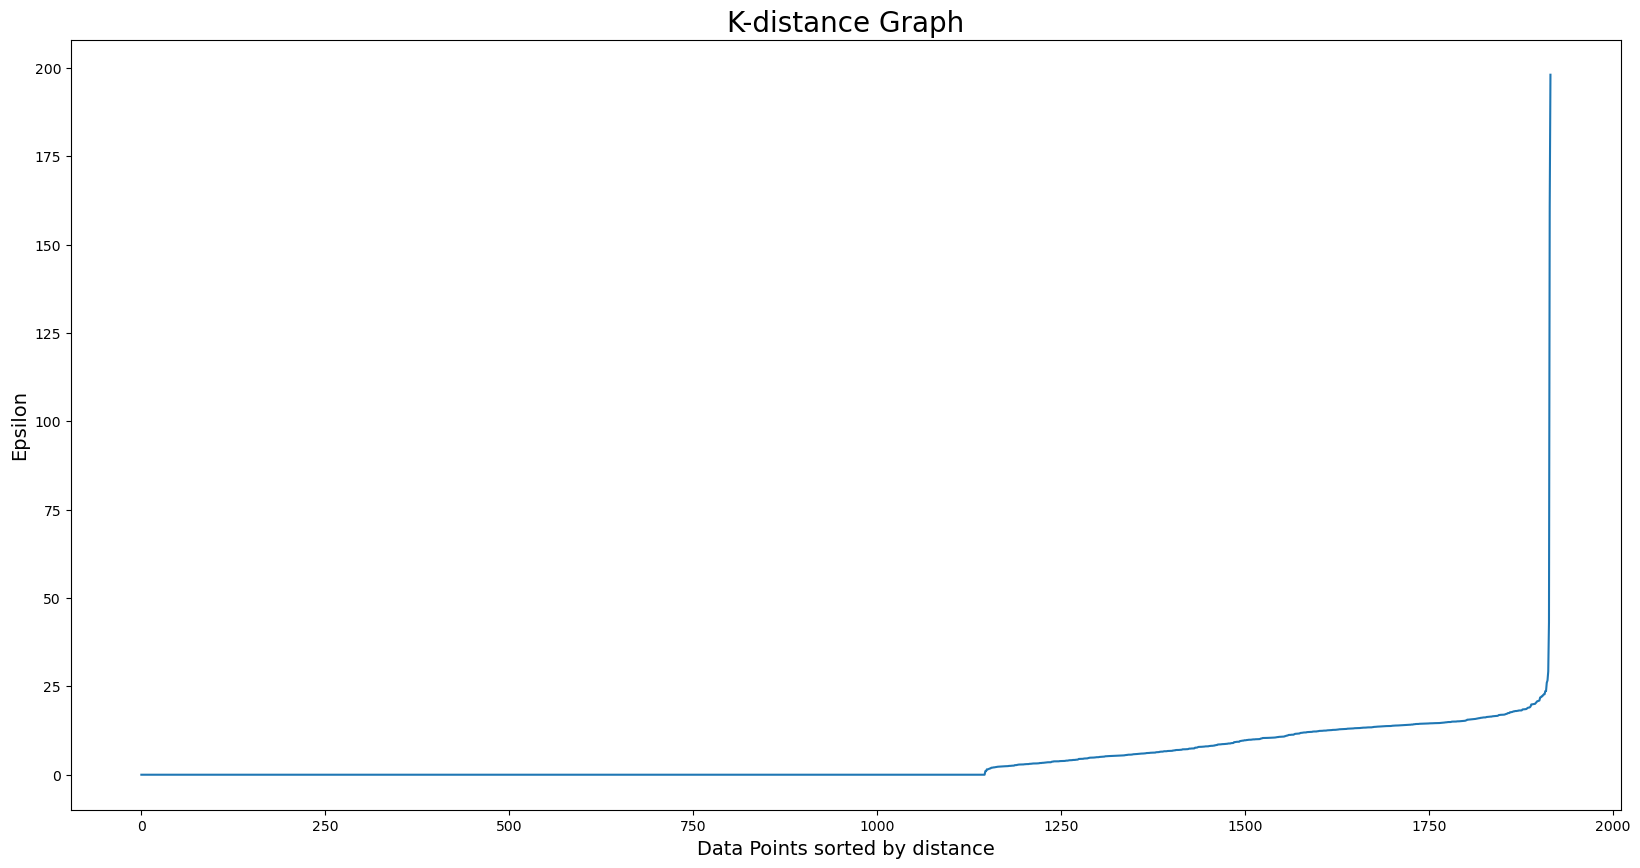

In [345]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [346]:

dbscan = DBSCAN(eps=25.0, min_samples=70)
dbscan.fit(std_emb)
cluster_labels = dbscan.labels_
coords = std_emb
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [347]:
cluster_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [348]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 37


In [349]:
df_7["Cluster_label"]=cluster_labels

In [127]:
# df_7.to_csv(path_folder)

### Local Outlier factor - topic 7

In [350]:

# TF-IDF vectorization
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(df_grp["V_COMMENTS_2"].get_group(9).values)

# Apply Local Outlier Factor
n_neighbors = 125
contamination = 0.25 # Percentage of outliers expected in the dataset
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
outlier_labels = lof.fit_predict(std_emb)




In [352]:
# Define parameter grid
param_grid = {
    'n_neighbors': [50, 70,100,150],
    'contamination': [0.5, 0.1, 0.2,0.4,]
}


# Perform grid search with unsupervised evaluation
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid, scoring=silhouette_score)
grid_search.fit(std_emb)  # X: feature matrix

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate silhouette score
silhouette = silhouette_score(std_emb, grid_search.best_estimator_.negative_outlier_factor_)
print("Silhouette Score:", silhouette)


Best Parameters: {'contamination': 0.5, 'n_neighbors': 50}
Silhouette Score: 0.1006295481771058


In [357]:
# Apply Local Outlier Factor
n_neighbors = 50
contamination = 0.50 # Percentage of outliers expected in the dataset
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
outlier_labels = lof.fit_predict(std_emb)


In [358]:
df_7["cluster_labels_lof"]=outlier_labels

In [359]:
df_7["cluster_labels_lof"].unique()

array([-1,  1])

In [360]:
df_7.to_csv("C:/Users/MBBLABS/Clustering_-_Anomaly_detection/7th_topic.csv")

In [172]:
# df_7.to_csv(path_folder)

## DBSCAN -19

In [20]:
embeddings_19 = []
for _, row in df_groups.get_group(19).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings_19.append(cls_embedding)

In [21]:
df_19=df_groups.get_group(19)
vectors_19=embeddings_19

In [22]:
embeddings_arr_19=[i.numpy().flatten() for i in embeddings_19]

In [23]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
std_emb=sc.fit_transform(embeddings_19)

ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [ ]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs_19 = neigh.fit(std_emb)


In [ ]:
distances,indices=nbrs.kneighbors(embeddings_arr_19)


In [ ]:
indices

In [ ]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [ ]:

dbscan = DBSCAN(eps=2.0, min_samples=50)
dbscan.fit(std_emb)
cluster_labels = dbscan.labels_
coords = std_emb
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [ ]:
cluster_labels

In [ ]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

In [116]:
df_19["Cluster_label"]=cluster_labels

In [117]:
# Filter out noise points
# core_samples_mask = labels != -1
filtered_X = df_19[df_19["Cluster_label"]!=-1]
filtered_labels = cluster_labels[cluster_labels!=-1]


# Calculate silhouette score
if len(set(filtered_labels)) > 1:  # Silhouette score needs at least 2 clusters
    score = silhouette_score(filtered_X, filtered_labels)
    print("Silhouette Score:", score)
else:
    print("Not enough clusters to calculate silhouette score")

Not enough clusters to calculate silhouette score


In [153]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/19th_topic.csv")


In [154]:
df_19.to_csv(path_folder)

## DBSCAN -11

In [163]:
embeddings = []
for _, row in df_groups.get_group(11).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [164]:
df_11=df_groups.get_group(11)
vectors=embeddings

In [165]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [186]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [166]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embeddings_arr)


In [167]:
distances,indices=nbrs.kneighbors(embeddings_arr)


In [168]:
indices

array([[   0, 4489,   38, 3460],
       [   5,    1,  462,  800],
       [   2,  643, 1054, 1057],
       ...,
       [4605, 2035,  826, 3810],
       [4606, 1667, 3975, 2875],
       [4607, 3478, 4269, 3451]], dtype=int64)

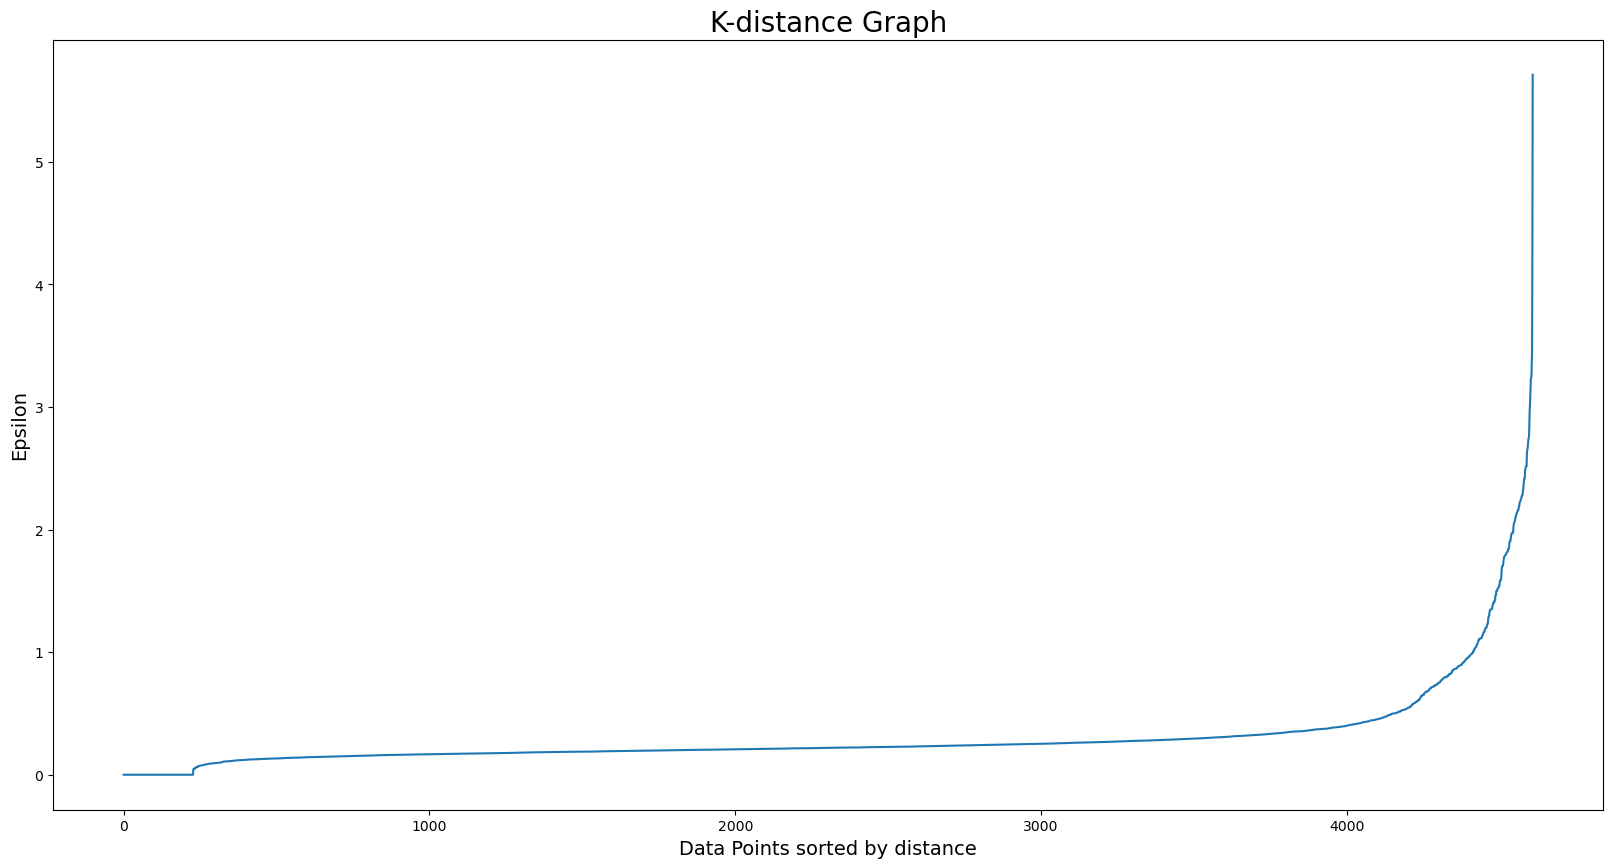

In [169]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [170]:

dbscan = DBSCAN(eps=0.5, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [171]:
cluster_labels

array([-1, -1, -1, ...,  0, -1,  0], dtype=int64)

In [172]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 5
Estimated no. of noise points: 1695


In [173]:
df_11["Cluster_label"]=cluster_labels

In [187]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/11th_topic.csv")


In [188]:
df_11.to_csv(path_folder)

## DBSCAN -12

In [189]:
embeddings = []
for _, row in df_groups.get_group(12).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [190]:
df_12=df_groups.get_group(12)
vectors=embeddings

In [191]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [186]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [192]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(std_emb)


NameError: name 'std_emb' is not defined

In [ ]:
distances,indices=nbrs.kneighbors(embeddings_arr)


In [ ]:
indices

In [ ]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [191]:

dbscan = DBSCAN(eps=20.0, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [192]:
cluster_labels

array([ 0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
       -1, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [193]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 70


In [194]:
df_12["Cluster_label"]=cluster_labels

In [ ]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/12th_topic.csv)


In [ ]:
df_12.to_csv(path_folder)

## DBSCAN 9

In [ ]:
embeddings = []
for _, row in df_groups.get_group(9).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

In [184]:
df_9=df_groups.get_group(9)
vectors=embeddings

In [185]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [186]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# std_emb=sc.fit_transform(embeddings_arr)

In [187]:
from sklearn.neighbors import NearestNeighbors
# vectors = vectorizer.fit_transform(df_temp["V_COMMENTS_2"])
# dbscan = DBSCAN(eps=1.0, min_samples=5)
# dbscan.fit(vectors)
# cluster_labels = dbscan.labels_
# coords = vectors.toarray()
# no_clusters = len(np.unique(cluster_labels) )
# no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)


neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(std_emb)
distances,indices=nbrs.kneighbors(embeddings_arr)

In [189]:
indices

array([[  0, 389],
       [  1,  11],
       [  2, 711],
       ...,
       [950, 258],
       [951, 379],
       [952, 515]], dtype=int64)

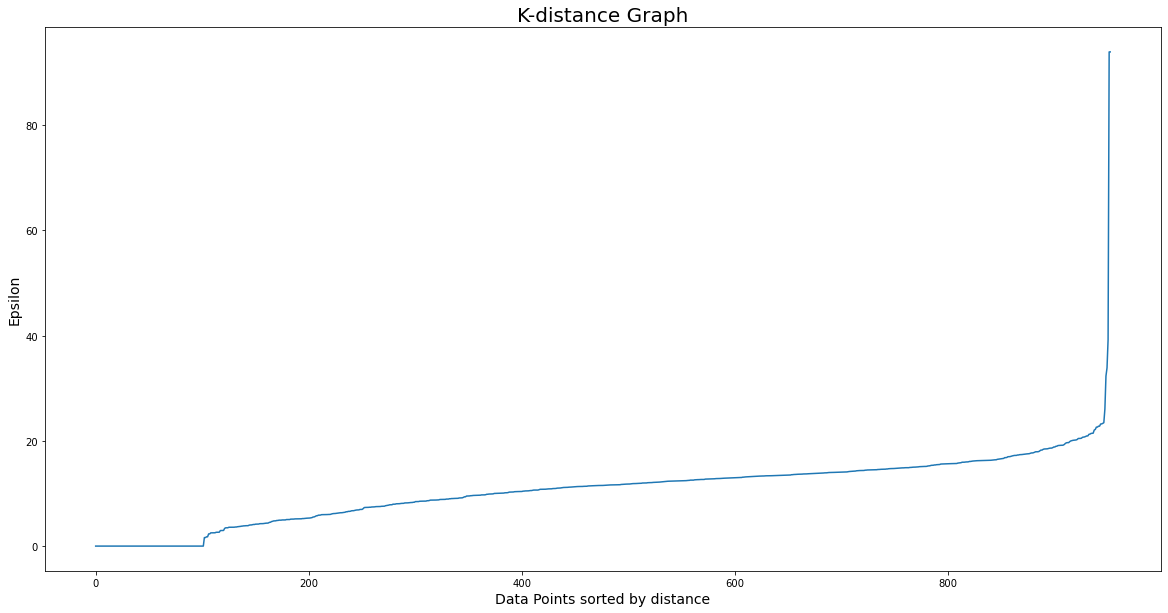

In [190]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [191]:

dbscan = DBSCAN(eps=22.0, min_samples=50)
dbscan.fit(embeddings_arr)
cluster_labels = dbscan.labels_
coords = embeddings_arr
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

In [192]:
cluster_labels

array([ 0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
       -1, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [193]:
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 70


In [194]:
df_9["Cluster_label"]=cluster_labels

In [ ]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_folder=os.path.join(folder_path,"Comment analysis (Ind)/Comments_exploration_all_anchors/All_value_counts/DBSCAN/9th_topic.csv)


In [ ]:
df_9.to_csv(path_folder)

In [ ]:
6     41846
3     31042
14    25252
4     18335
8     15784
5     13528
10    12982
17    10520
16     9395
0      9306
1      8627


## DBSCAN 1

In [ ]:
for i in range(1,2):
    embeddings = []
    for _, row in df_groups.get_group(i).iterrows():
        sentence1 = row['V_COMMENTS_PROCESSED']
        cls_embedding = process_pair(sentence1)
        embeddings.append(cls_embedding)
    embeddings_arr=[i.numpy().flatten() for i in embeddings]
    neigh = NearestNeighbors(n_neighbors=4)
    nbrs = neigh.fit(std_emb)
    distances,indices=nbrs.kneighbors(embeddings_arr)

In [ ]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [ ]:

# 

## Local Outlier factor

In [17]:
df_13=df_groups.get_group(13)
# vectors=embeddings

In [20]:
embeddings = []
for _, row in df_groups.get_group(13).iterrows():
    sentence1 = row['V_COMMENTS_PROCESSED']
    cls_embedding = process_pair(sentence1)
    embeddings.append(cls_embedding)

# Stack the embeddings into a single tensor
# embeddings_tensor = torch.stack(embeddings)



In [21]:
embeddings_arr=[i.numpy().flatten() for i in embeddings]

In [38]:
# Scaling of embeddings

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
std_emb=sc.fit_transform(embeddings_arr)



In [39]:

# TF-IDF vectorization
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(df_grp["V_COMMENTS_2"].get_group(9).values)

# Apply Local Outlier Factor
n_neighbors = 125
contamination = 0.25 # Percentage of outliers expected in the dataset
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
outlier_labels = lof.fit_predict(embeddings_arr)




In [40]:
df_13["cluster_labels"]=outlier_labels

In [41]:
df_13["cluster_labels"].unique()

array([ 1, -1])

In [42]:
# Define parameter grid
param_grid = {
    'n_neighbors': [50, 70,100,150],
    'contamination': [0.5, 0.1, 0.2,0.4,]
}





# Perform grid search with unsupervised evaluation
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid, scoring=silhouette_score)
grid_search.fit(embeddings_arr)  # X: feature matrix

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate silhouette score
silhouette = silhouette_score(embeddings_arr, grid_search.best_estimator_.negative_outlier_factor_)
print("Silhouette Score:", silhouette)


Best Parameters: {'contamination': 0.5, 'n_neighbors': 50}
Silhouette Score: 0.250759864464316


# using word embeddings - identifying the outliers - Not going to work

In [ ]:
# glove,word2vec cbow

In [10]:
# importing all necessary modules
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df["Tokens"].to_list()

[['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'year', 'birth', 'yob'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'date', 'birth', 'dob'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['mismatch', 'full', 'name', 'sound', 'similar'],
 ['match', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'nric'],
 ['match', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'date', 'birth', 'dob'],
 ['mismatch',
  'yobage',
  'comparison',
  'make',
  'customer',
  'yob',
  'bank',
  'kyc',
  'uco',
  'watchperson',
  'yob',
  'refinitive'],
 ['mismatch', 'identification', 'number', 'nric'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'i', 'd', 'number', 'nric'],
 ['mismatch', 'full', 'name', 'name', 'sound', 'similar'],
 ['mismatch

In [12]:
model1= gensim.models.Word2Vec(df["Tokens"].to_list(), min_count=1,
                                vector_size=100, window=5,sg=0)

In [13]:
# pickle.dump(,)
import pickle
pickle.dump(model1,open("word2vec.sav","wb"))

In [ ]:
# df_grp["Tokens"].get_group(1.0).apply(lambda x:np.array([model1.wv[i] for i in x]).shape)

In [1]:
df["Vect"]=df["Tokens"].apply(lambda x:np.sum(np.array([model1.wv[i] for i in x]),axis=0)/(len(x)))

NameError: name 'df' is not defined

In [ ]:
df["Vect 2"]=df[" TF IDF Topic words"].apply(lambda x:np.sum(np.array([model1.wv[i] for i in x]),axis=0)/(len(x)))

In [ ]:
import numpy as np
from numpy.linalg import norm

In [ ]:
df["sim_score"]=df[["Vect","Vect 2"]].apply(lambda x: cosine_similarity([x[0]],[x[1]]),axis=1)

In [ ]:
df["sim_score"]=df["sim_score"].apply(lambda x: x[0][0])
df["sim_score"]

In [66]:
df["sim_score"]=df["sim_score"].apply(lambda x: np.abs(x))

In [ ]:
# df[df["sim_score"].apply(lambda x: type(x)==np.ndarray)]["V_COMMENTS_2"].apply(lambda x: len(x))

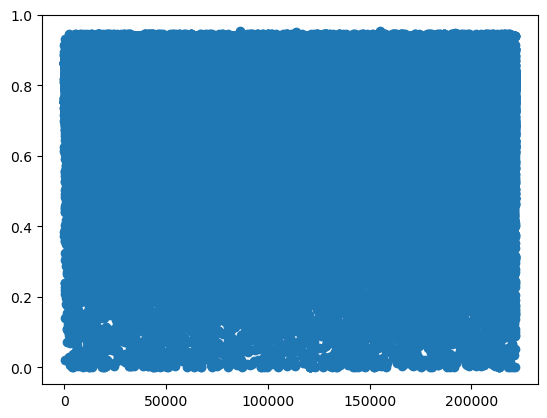

In [67]:
plt.scatter(df.index,df["sim_score"])

(array([ 1108.,  1595.,  2809.,  5421., 10566., 16970., 25518., 47586.,
        70774., 39184.]),
 array([5.57824969e-05, 9.53092448e-02, 1.90562707e-01, 2.85816170e-01,
        3.81069632e-01, 4.76323094e-01, 5.71576557e-01, 6.66830019e-01,
        7.62083481e-01, 8.57336944e-01, 9.52590406e-01]),
 <BarContainer object of 10 artists>)

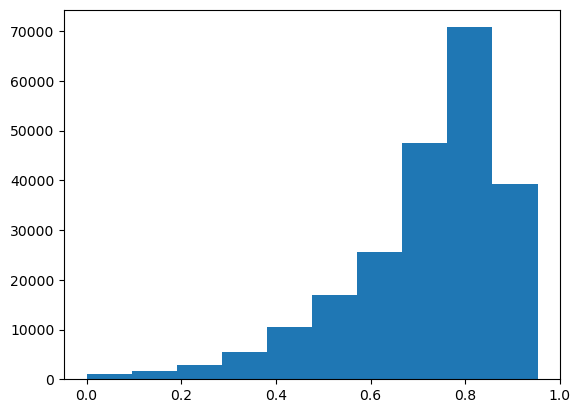

In [68]:
plt.hist(df["sim_score"])

{'whiskers': [<matplotlib.lines.Line2D at 0x275928f03a0>,
 'caps': [<matplotlib.lines.Line2D at 0x275928f0940>,
 'boxes': [<matplotlib.lines.Line2D at 0x275928f00d0>],
 'medians': [<matplotlib.lines.Line2D at 0x275928f0ee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x275928fd220>],
 'means': []}

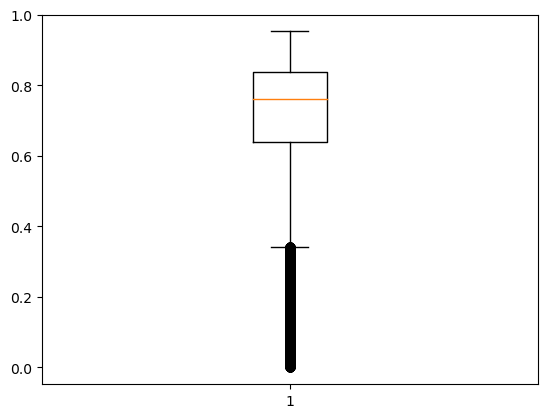

In [69]:
plt.boxplot(df["sim_score"])

In [70]:
q1,q2,q3=np.percentile(df["sim_score"],[25,50,75])
print(q1,q2,q3)

0.6396217346191406 0.7605907320976257 0.8385270833969116


In [73]:
y=q1-1.5*(q3-q1)
df[df["sim_score"].apply(lambda x: x<y)].to_csv("Outliers_word2vec_cbow.csv")

In [74]:
df1=df[df["sim_score"].apply(lambda x: x<y)]

In [75]:
df1["TF_tfidf_Topic_No"].value_counts()

1     1867
12    1065
15     920
14     905
18     742
2      683
17     318
10     316
13     283
19     265
7      262
9      179
8      110
6       91
5       80
0       77
16      14
Name: TF_tfidf_Topic_No, dtype: int64

In [ ]:
df[df_grp["sim_score"].transform(lambda x: (x-x.mean())/x.std()).apply(lambda x:True if abs(x)<x3 else False)]

# GlOVE , T-SNE , PCA - Not required

In [ ]:
# for i in range(10):
#      plt.boxplot(df_grp["sim_score"].get_group(int(i)))
for i in list(df_grp.groups.keys()):
    print(i)
    print(df_grp["sim_score"].get_group(i).mean())

In [ ]:
### PCA

In [ ]:
from sklearn.decomposition import PCA
labels = []
tokens = []
for word in model1.wv.index_to_key:
        tokens.append(model1.wv[word])
        labels.append(word)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(tokens)




In [ ]:
# df_1=df_grp.get_group(1.0)
# df_grp["Topic words"]

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [ ]:
# Convert GloVe format to word2vec format
glove_input_file = 'glove.6B/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B/glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
# Load the converted model
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)



# Example usage
vector = glove_model['example']
similar_words = glove_model.most_similar('example')

print("Vector representation of 'example':", vector)
print("Similar words to 'example':", similar_words)

In [ ]:
### T-SNE & PCA

In [ ]:
def tsne_plot():
    labels = []
    tokens = []
    
    # Extracting words and their vectors from our trained model1 
    for word in model1.wv.index_to_key:
        tokens.append(model1.wv[word])
        labels.append(word)
    
    # Train t-SNE 
    tsne_model1 = TSNE(perplexity=45, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model1.fit_transform(tokens)
    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.xlabel("dimension 1")
        plt.ylabel("dimension 2")
    plt.show()
# Words that occur atleast











In [ ]:
# tsne_plot()

In [ ]:
len(tokens)

In [ ]:
vectors = vectorizer.fit_transform(df["V_COMMENTS_2"])

In [ ]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(vectors)
pca.components_

In [ ]:
# Step 1: Create word vectors for each word in the text data
word_vectors = []
for sentence in text_data:
    tokens = sentence.split()
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if vectors:
        word_vectors.append(np.mean(vectors, axis=0))

# Step 2: Apply PCA
word_vectors = np.array(word_vectors)
num_components = 2  # Choose the number of components
pca = PCA(n_components=num_components)
word_vectors_pca = pca.fit_transform(word_vectors)

# Step 3: Analysis
# Let's print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Step 4: Visualize the transformed data
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(word_vectors_pca)):
    plt.scatter(word_vectors_pca[i, 0], word_vectors_pca[i, 1], label=f"Sentence {i+1}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.title("PCA on Word2Vec Embeddings")
plt.show()

